### Step 2: Image Condition Generation

In Step 1, i created 'samples_step1_person_limited.csv', where each row contains 'image_path', 'bbox', 'category', and 'size_group' for each sample.

Step 2 reads this CSV and for each sample image, geneartes six different image conditions and saves them into separate folders.

- orig_full: original image without any modification
- orig_crop: cropped image around the bounding box to make small objects more visible
- downscale: image is downscaled and then upscaled to simulate resoltuion loss
- motion_blur: motion blur is applied to simulate camera or object movement
- occlusion: part of the object inside the bounding box is covered with a black patch
- bg_blur: background is blurred while the object region remains sharp

The goal of Step 2 is not data augmentation, but controlled condition analysis. By keeping the object identity the same and changing only one visual factor at a time, Step 3 can analyze why CNN performance degrades on small objects under specific conditions.

This step prepares a clean and interpretable dataset for failure analysis rather than training.

In [1]:
import os
import numpy as np
import pandas as pd
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

SAMPLES_CSV = "data/samples_step1_person_limited.csv"

OUT_ROOT = "data/processed_step2"
os.makedirs(OUT_ROOT, exist_ok=True)

CONDITIONS = ["orig_full", "orig_crop", "downscale", "motion_blur", "occlusion", "bg_blur"]
for c in CONDITIONS:
    os.makedirs(os.path.join(OUT_ROOT, c), exist_ok=True)

df = pd.read_csv(SAMPLES_CSV)
print("Loaded rows: ", len(df))
df.head()

Loaded rows:  600


,image_id,file_name,image_path,ann_id,category_id,category_name,bbox_x,bbox_y,bbox_w,bbox_h,bbox_area,img_area,area_ratio,size_group
0,468332,000000468332.jpg,data/coco/val2017/000000468332.jpg,1310775,1,person,50.14,59.45,12.97,36.39,471.9783,271360,0.001739,small
1,132587,000000132587.jpg,data/coco/val2017/000000132587.jpg,2159193,1,person,232.59,0.46,32.85,35.07,1152.0495,272000,0.004235,small
2,158548,000000158548.jpg,data/coco/val2017/000000158548.jpg,224764,1,person,225.43,190.91,11.35,15.82,179.5570,308480,0.000582,small
3,412894,000000412894.jpg,data/coco/val2017/000000412894.jpg,2206114,1,person,397.08,410.66,10.62,29.88,317.3256,273280,0.001161,small
4,438955,000000438955.jpg,data/coco/val2017/000000438955.jpg,1304759,1,person,358.83,96.69,19.07,17.70,337.5390,193920,0.001741,small


In [2]:
# Limits a value to stay within a fixed range - keep bounding box coordinates inside image boundaries
def clamp(val, low, high):
    return max(low, min(high, val))

# Expand bbox by margin and clamp to image boundaries
def bbox_with_margin(x, y, w, h, img_w, img_h, margin_ratio=0.25):
    mx = int(w * margin_ratio)
    my = int(h * margin_ratio)

    x1 = clamp(int(x) - mx, 0, img_w - 1)
    y1 = clamp(int(y) - my, 0, img_h - 1)
    x2 = clamp(int(x + w) + mx, 0, img_w - 1)
    y2 = clamp(int(y + h) + my, 0, img_h - 1)

    if x2 <= x1 + 1 or y2 <= y1 + 1:
        return None

    return x1, y1, x2, y2

# Crop bbox region including the margin from the image
def crop_roi(img_bgr, x, y, w, h, margin_ratio=0.25):
    H, W = img_bgr.shape[:2]
    roi = bbox_with_margin(x, y, w, h, W, H, margin_ratio=margin_ratio)
    if roi is None:
        return None, None
    x1, y1, x2, y2 = roi
    return img_bgr[y1:y2, x1:x2].copy(), roi # cropped image and ROI coords

# Simulates loss of fine details (small objects get destroyed)
def downscale_upsample(img_bgr, scale=0.5):
    H, W = img_bgr.shape[:2]
    new_w = max(2, int(W * scale))
    new_h = max(2, int(H * scale))

    small = cv2.resize(img_bgr, (new_w, new_h), interpolation=cv2.INTER_AREA)
    back = cv2.resize(small, (W, H), interpolation=cv2.INTER_LINEAR)
    return back

# Apply simple motion blur using custom kernel
def motion_blur(img_bgr, k_size=15, direction="horizontal"):
    k_size = int(k_size)
    if k_size < 3:
        return img_bgr.copy()

    kernel = np.zeros((k_size, k_size), dtype=np.float32)
    if direction == "vertical":
        kernel[:, k_size // 2] = 1.0
    else:
        kernel[k_size // 2, :] = 1.0

    kernel /= kernel.sum() # normalization - maintain image intensity
    return cv2.filter2D(img_bgr, -1, kernel)

# Put black patch inside the bbox region (partial)
def occlude_bbox(img_bgr, x, y, w, h, occlusion_ratio=0.35):
    image_result = img_bgr.copy()
    H, W = image_result.shape[:2]

    x, y, w, h = int(x), int(y), int(w), int(h)
    
    occ_w = max(1, int(w * occlusion_ratio))
    occ_h = max(1, int(h * occlusion_ratio))

    ox1 = clamp(x + w // 2 - occ_w // 2, 0, W - 1)
    oy1 = clamp(y + h // 2 - occ_h // 2, 0, H - 1)
    ox2 = clamp(ox1 + occ_w, 0, W - 1)
    oy2 = clamp(oy1 + occ_h, 0, H - 1)

    image_result[oy1:oy2, ox1:ox2] = (0, 0, 0)
    return image_result

# Blur background while keeping bbox + margin region sharp -> simulate focus on object
def background_blur(img_bgr, x, y, w, h, k_size=21, margin_ratio=0.10):
    H, W = img_bgr.shape[:2]
    x, y, w, h = int(x), int(y), int(w), int(h)

    roi = bbox_with_margin(x, y, w, h, W, H, margin_ratio=margin_ratio)
    if roi is None:
        return img_bgr.copy()

    x1, y1, x2, y2 = roi

    # Gaussian blur
    k_size = int(k_size)
    blurred = cv2.GaussianBlur(img_bgr, (k_size, k_size), 0)
    result = blurred.copy()

    result[y1:y2, x1:x2] = img_bgr[y1:y2, x1:x2]
    return result

In [5]:
# Create dict of {condition_name: image_bgr}
def make_condition_images(img_bgr, row):
    x = float(row["bbox_x"])
    y = float(row["bbox_y"])
    w = float(row["bbox_w"])
    h = float(row["bbox_h"])

    cond_dict = {}
    cond_dict["orig_full"] = img_bgr.copy()

    crop, _ = crop_roi(img_bgr, x, y, w, h, margin_ratio=0.25)
    cond_dict["orig_crop"] = crop if crop is not None else img_bgr.copy()

    cond_dict["downscale"] = downscale_upsample(img_bgr, scale=0.5)

    cond_dict["motion_blur"] = motion_blur(img_bgr, k_size=15, direction="horizontal")

    cond_dict["occlusion"] = occlude_bbox(img_bgr, x, y, w, h, occlusion_ratio=0.35)

    cond_dict["bg_blur"] = background_blur(img_bgr, x, y, w, h, k_size=21, margin_ratio=0.10)

    return cond_dict

In [7]:
for _, row in tqdm(df.iterrows(), total=len(df)):
    img_path = row["image_path"]

    img_bgr = cv2.imread(img_path)

    image_id = int(row["image_id"])
    ann_id = int(row["ann_id"])
    base_name = f"{image_id}_{ann_id}.jpg"

    cond_imgs = make_condition_images(img_bgr, row)

    for cond_name, cond_img in cond_imgs.items():
        result_path = os.path.join(OUT_ROOT, cond_name, base_name)
        cv2.imwrite(result_path, cond_img)

print("Output root:", OUT_ROOT)

100%|██████████| 600/600 [00:08<00:00, 70.88it/s]

Output root: data/processed_step2


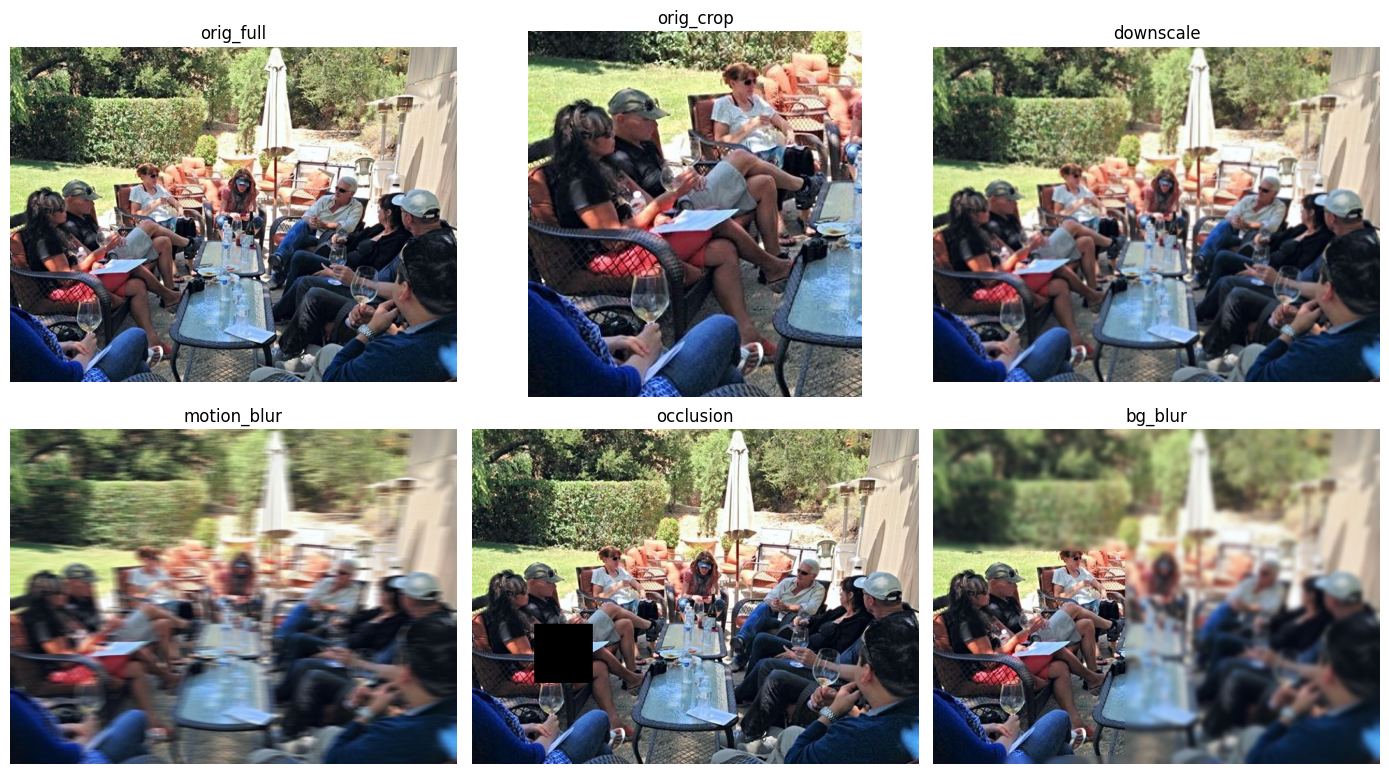

In [9]:
def show_grid_one():
    r = df.sample(1, random_state=0).iloc[0]
    base = f"{int(r.image_id)}_{int(r.ann_id)}.jpg"
    plt.figure(figsize=(14, 8))

    for i, cond in enumerate(CONDITIONS):
        p = os.path.join(OUT_ROOT, cond, base)
        img = cv2.imread(p)

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.subplot(2, 3, i + 1)
        plt.imshow(img)
        plt.axis("off")
        plt.title(cond)

    plt.tight_layout()
    plt.show()

show_grid_one()


The figure shows different image conditions generated from the same object instance. Each condition simulates a common difficulty in real-world object detection.

- orig_full shows the object in a cluttered scene.
- orig_crop reduces background by focusing on the object region.
- downscale removes fine details by lowering resoltuion.
- motion_blur simulates camera or object movement.
- occlusion partially blocks the object.
- bg_blur blurs the background while keeping the object sharp.

These results confirm that each condition meaningfully modifies the image. They provide a controlled setup to analyze CNN performance under different degradation types.